In [1]:
import pandas as pd
import seaborn as sns
import spacy
import re
from collections import Counter
import matplotlib.pyplot as plt
from spacytextblob.spacytextblob import SpacyTextBlob

## Load and Inspect the Dataset (Overview of the data)

In [3]:
df = pd.read_csv("../data/2. fake_news_data.csv");
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            198 non-null    object
 1   text             198 non-null    object
 2   date             198 non-null    object
 3   fake_or_factual  198 non-null    object
dtypes: object(4)
memory usage: 6.3+ KB
None


,title,text,date,fake_or_factual
0,HOLLYWEIRD LIB SUSAN SARANDON Compares Muslim ...,There are two small problems with your analogy...,"Dec 30, 2015",Fake News
1,Elijah Cummings Called Trump Out To His Face ...,Buried in Trump s bonkers interview with New Y...,"April 6, 2017",Fake News
2,Hillary Clinton Says Half Her Cabinet Will Be...,"Women make up over 50 percent of this country,...","April 26, 2016",Fake News
3,Russian bombing of U.S.-backed forces being di...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,"September 18, 2017",Factual News
4,Britain says window to restore Northern Irelan...,BELFAST (Reuters) - Northern Ireland s politic...,"September 4, 2017",Factual News


duplicates:  0


Text(0.5, 1.0, 'counts of article classification')

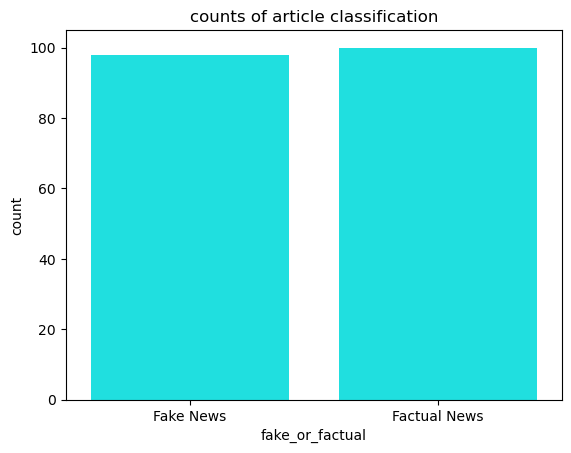

In [4]:
print("duplicates: ", df.duplicated().sum())
sns.countplot(x = df["fake_or_factual"], color = "cyan")
plt.title("counts of article classification")

### We have a balanced dataset

## Compare News Lengths

Text(0.5, 1.0, 'Lengths of Fake news')

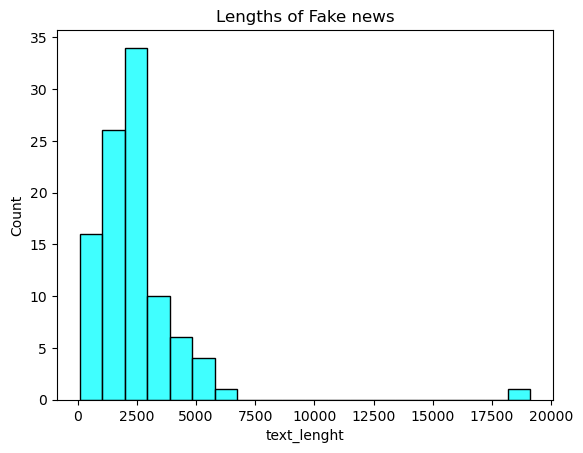

In [5]:
df["text_lenght"] = df["text"].map(len)
sns.histplot(x = "text_lenght", data = df.loc[df["fake_or_factual"] == "Fake News"], bins=20, color="cyan")
plt.title("Lengths of Fake news")

Text(0.5, 1.0, 'Lengths of Factual/Real news')

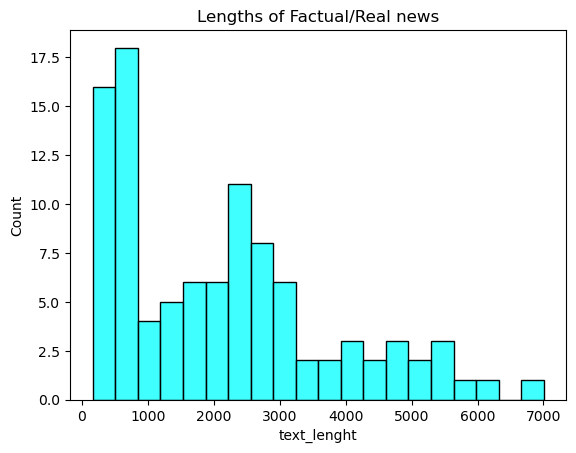

In [6]:
sns.histplot(x = "text_lenght", data = df.loc[df["fake_or_factual"] == "Factual News"], bins=20, color="cyan")
plt.title("Lengths of Factual/Real news")

### Observation:
- The average length of fake news articles is slightly shorter than that of factual news articles.
- Although the difference is not substantial, this might suggest that fake news tends to be more concise or simplified.
- This insight can help us understand text characteristics and might be useful for feature engineering later.

### Observations on Word Frequencies

In [ ]:
def plot_words (words):
    plt.figure(figsize=(10,6))
    sns.barplot(
    x="count", 
    y="word", 
    data=words,
        color="cyan",
    )
    plt.title("Top Words Frequency")
    plt.xlabel("Frequency")
    plt.ylabel("Word")
    plt.show()


In [ ]:
factual_news = df.loc[df["fake_or_factual"] == "Factual News"]["text"].sum().split();
factual_words = pd.DataFrame(Counter(factual_news).most_common(20), columns=["word", "count"]);
plot_words(factual_words)

In [ ]:
fake_news = df.loc[df["fake_or_factual"] == "Fake News"]["text"].sum().split();
fake_words_df = pd.DataFrame(Counter(fake_news).most_common(20), columns =["word", "count"])
plot_words(fake_words_df)

- We compared the frequency of words in fake news versus factual news to check for any noticeable patterns or biases.
- The analysis shows that the overall word usage is quite similar between fake and factual news.
- There are no strong biases or unique words that distinctly separate fake news from factual news based purely on frequency.

## POS Tagging

In [ ]:
# Data Cleaning
# Removed prefixes before the first dash to focus on main content.
# Converted text to lowercase and removed punctuation.
nlp = spacy.load("en_core_web_sm");

def get_lemma_no_stop(doc):
    return [token.lemma_ for token in doc if not token.is_stop]

def get_pos_no_stop(doc):
    return [token.pos_ for token in doc if not token.is_stop]

def plot_pos_tags(pos, title = "POS Distribution in Factual News"):
    factual_pos_list = [pos for sublist in factual_pos for pos in sublist]
    pos_counts = Counter(factual_pos_list)

    plt.figure(figsize=(10,6))
    sns.barplot(x=list(pos_counts.keys()), y=list(pos_counts.values()))
    plt.title(title)
    plt.show()

df["text"] = df["text"].str.replace(r'^.*?-\s*', '', regex=True);
df["text_lower"] = df["text"].map(lambda x : re.sub(r"[^\w\s]", "", x.lower()) );
df["text_doc"] = df["text_lower"].map(lambda x : nlp(x))
df["text_lemma_no_stw"] = df["text_doc"].apply(get_lemma_no_stop)
df["text_pos"] = df["text_doc"].apply(get_pos_no_stop)
factual_pos = df[df["fake_or_factual"] == "Factual News"]["text_pos"]

plot_pos_tags(factual_pos)

In [ ]:
fake_pos = df[df["fake_or_factual"] == "Fake News"]["text_pos"]
plot_pos_tags(fake_pos, title = "POS Distribution in Fake News")

### Observation
The distribution of POS tags (such as nouns, verbs, adjectives, and adverbs) appeared relatively similar across both classes.
This indicates that syntactic structure alone may not be a strong distinguishing factor for identifying fake news.

## SENTIMENT ANALYSIS

In [ ]:
# nlp.add_pipe('spacytextblob')

def get_sentiment(text):
    doc =  nlp(text);
    if doc._.blob.polarity > 0 :
        return "positive";
    elif doc._.blob.polarity < 0 : 
        return "negative";
    return "neutral"

def analyze_sentiment(df: pd.DataFrame, label_col: str, text_col: str, label_value: str):
    subset = df[df[label_col] == label_value].copy()
    subset["joined_text"] = subset[text_col].map(lambda x: " ".join(x) if isinstance(x, list) else str(x))
    subset["sentiment"] = subset["joined_text"].map(get_sentiment)
    
    plt.figure(figsize=(6, 4))
    sns.countplot(x=subset["sentiment"])
    plt.title(f"Sentiment Distribution for {label_value}")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.show()
    
    return subset

fake_sentiment_df = analyze_sentiment(df, "fake_or_factual", "text_lemma_no_stw", "Fake News")
factual_sentiment_df = analyze_sentiment(df, "fake_or_factual", "text_lemma_no_stw", "Factual News")


### Observation
The sentiment analysis revealed that both factual and fake news articles exhibit a similar distribution of positive, negative, and neutral sentiments. This indicates that emotional tone or sentiment polarity alone is not a strong distinguishing factor between the two categories.

## CONCLUSION

The primary objective of this analysis was to determine whether linguistic or structural patterns could be identified between fake and factual news articles prior to model development. Through a series of exploratory steps including text length comparison, word frequency analysis, POS tagging, and sentiment evaluation, we observed that both categories exhibit strong similarities in word usage, grammatical patterns, and overall sentiment distribution.

These findings indicate that distinguishing fake from factual news based solely on linguistic features is challenging. As a result, we decided to train classification models such as Logistic Regression and Naive Bayes, which are capable of learning deeper, statistical distinctions within the data that may not be easily visible through direct observation.

The insights from this analysis directly informed the development of our Fake News Detection model, designed to automatically classify news content as fake or factual with improved accuracy and reliability.

In [ ]:
df[["text_lower", "fake_or_factual"]].to_csv("pre_processed_fake_news.csv", index = False)